In [1]:
import sympy as sym
import numpy as np
from numpy import linalg as la
import control as ctl
from scipy import linalg

#libraries for simulation
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio
import ae353_segbot

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
F_temp = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

F_temp = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [F_temp]])

In [3]:
e_l_eq = 0
e_h_eq = 0
v_eq = 40
w_eq = 0
theta_eq = 0
thetadot_eq = 0
tau_R_eq = 0
tau_L_eq = 0

In [4]:
#a slight change in code so I can rerun this without recalculating f with the long mechanics code
f = sym.Matrix([
    F_temp[0],
    F_temp[1],
    F_temp[2],
    F_temp[3],
    thetadot,
    F_temp[4]
])
#check that f = 0 @ equilibrium
f.subs([ (e_l, e_l_eq), (e_h, e_h_eq), (v, v_eq), (w, w_eq), (theta, theta_eq), (thetadot, thetadot_eq), (tau_R, tau_R_eq), (tau_L, tau_L_eq) ])

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

In [5]:
#calcualte A & B from jacobians
A = f.jacobian([e_l,
 e_h,
 v,
 w,
 theta,
 thetadot])
B = f.jacobian([
    tau_R, tau_L
])

In [6]:
#evaluate A and B at equilibrium
A = A.subs([ (e_l, e_l_eq), (e_h, e_h_eq), (v, v_eq), (w, w_eq), (theta, theta_eq), (thetadot, thetadot_eq), (tau_R, tau_R_eq), (tau_L, tau_L_eq) ])
B = B.subs([ (e_l, e_l_eq), (e_h, e_h_eq), (v, v_eq), (w, w_eq), (theta, theta_eq), (thetadot, thetadot_eq), (tau_R, tau_R_eq), (tau_L, tau_L_eq) ])

In [7]:
A = np.array(A).astype("float64")
B = np.array(B).astype("float64")

In [9]:
#verify controllability: rank should equal 6
W = ctl.ctrb(A,B)
la.matrix_rank(W)

6

In [10]:
#design a controller using LQR

#decide weights
#states: e_l, e_h, v, w, theta, thetadot
Q = np.array([1000000,100,100,100,100000000,10000])
Q = np.diag(Q)

#inputs tau_R, tau_L
R = np.array([10,10])
R = np.diag(R)

#calculate P and K
P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P

In [11]:
np.set_printoptions(suppress = True)
la.eig(A - B @ K)[0]

array([-2300.05946373 +0.j        ,   -13.35988261+22.90201229j,
         -13.35988261-22.90201229j,   -26.72241516 +0.j        ,
        -100.05714157 +0.j        ,    -0.00207612 +0.j        ])

Simulation and Results code

In [134]:
simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=False,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [135]:
slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

In [136]:
simulator.camera_backview()

In [137]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        x = np.array([lateral_error - e_l_eq,
            heading_error - e_h_eq,
            forward_speed - v_eq,
            turning_rate - w_eq,
            pitch_angle - theta_eq,
            pitch_rate - thetadot_eq], dtype=float)

        tau = -K @ x
        right_wheel_torque = tau[0]
        left_wheel_torque = tau[1]
        
        return right_wheel_torque, left_wheel_torque

In [138]:
controller = Controller()

In [139]:
simulator.reset(
    initial_speed=5.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)
controller.reset()
slider.value = 0.75

In [140]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.75, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid…

Simulated 1501 time steps in 30.5645 seconds (49.1092 time steps per second)


In [132]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

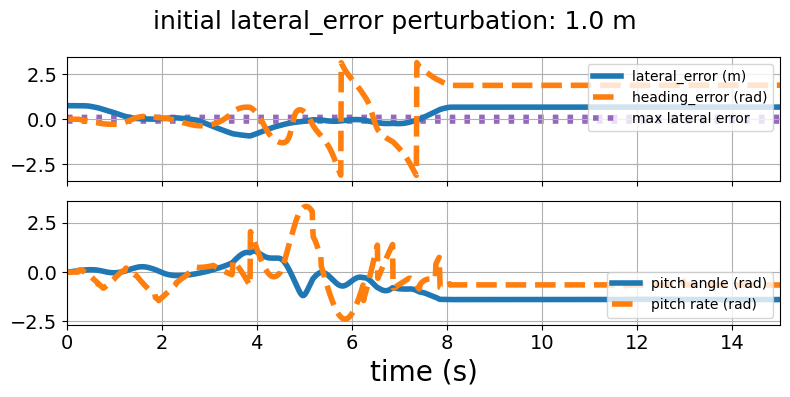

In [133]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_pitch) = plt.subplots(2, 1, figsize=(8, 4), height_ratios = [1,1], sharex=True)

fig.suptitle('initial lateral_error perturbation: 1.0 m', fontsize = 18)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.plot(
    data['t'], np.ones_like(data['t']) * 0.1,
    ':', label='max lateral error', linewidth=4, color='C4', zorder=0,
)
ax_pos.plot(
    data['t'], np.ones_like(data['t']) * -0.1,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, loc = 'upper right')
ax_pos.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, loc = 'lower right')
ax_pitch.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_pitch.set_xlabel('time (s)', fontsize=20)
ax_pitch.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [129]:
fig.savefig('initial_1.0.png', facecolor='white', transparent=False)

In [68]:
lateral_error = data['lateral_error'][500:]
np.max(abs(lateral_error))

0.3206718374564348

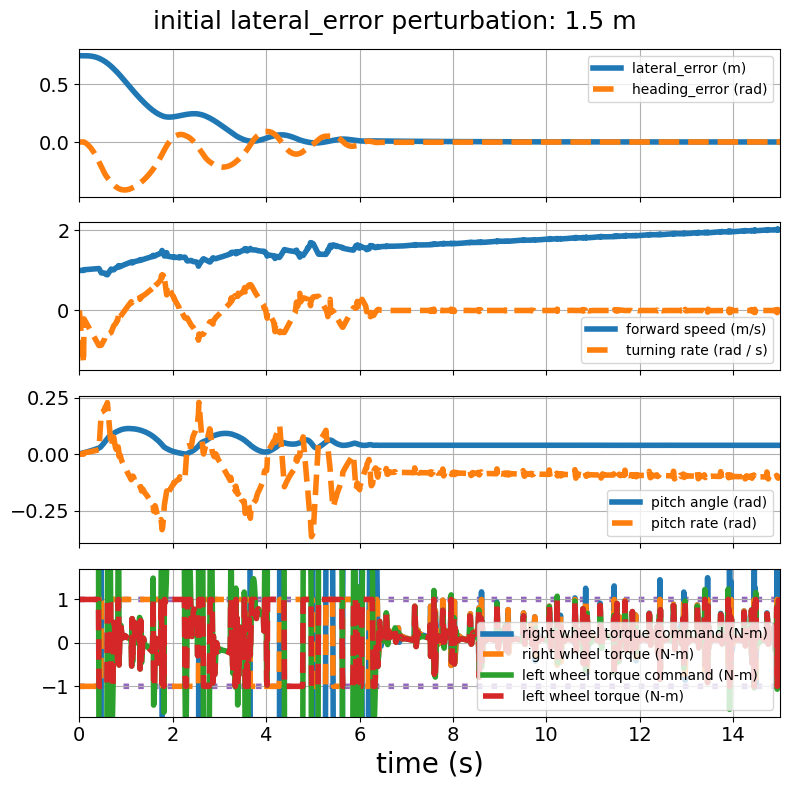

In [34]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

fig.suptitle('initial lateral_error perturbation: 0.25 m', fontsize = 18)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=10, loc = 'upper right')
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=10, loc = 'lower right')
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=10, loc = 'lower right')
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, loc = 'lower right')
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.7 * simulator.tau_max, 1.7 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [ ]:

0.5: 0.03329430520287591
0.75: 0.025
1.0: -0.182
1.5: failure